In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
def func_y(x):
    return np.sin(x)/x - x/10


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(8, 64),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(0.2))
            return layers
        
        self.model = nn.Sequential(
            *block(2, 128),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, x):
        return self.model(x)

In [4]:
train_data_x = np.linspace(-1,1,2048)
np.delete(train_data_x, 0)
train_data_y = func_y(train_data_x)
train_data = list(zip(train_data_x, train_data_y))
train_data = torch.tensor(train_data)

In [5]:
n_epochs = 200
batch_size = 32
lr = 0.0002
b1 = 0.5
b2 = 0.999

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

[Epoch 199/200] [Batch 57/2048] [D loss: 0.692447] [G loss: 0.696288]


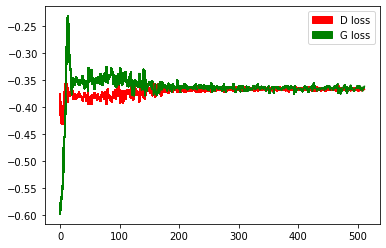

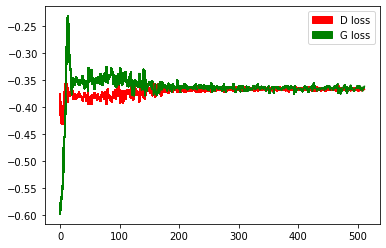

In [8]:
d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

sample_interval = 25

for epoch in range(n_epochs):
    for i, (data) in enumerate(train_loader):
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)          
        real_data = data.type(torch.FloatTensor).to(device)
        optimizer_G.zero_grad()
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 8))).to(device)
        generator_data = generator(noise)
        validity = discriminator(generator_data)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_pred = discriminator(real_data)
        d_real_loss = adversarial_loss(real_pred, valid)
        fake_pred = discriminator(generator_data.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(real_data) + i   
        if batches_done % sample_interval == 0:             
            d_loss_history.append(d_loss.cpu().detach())
            g_loss_history.append(g_loss.cpu().detach())            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(train_data), d_loss.item(), g_loss.item()) ) 
            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])           
            display.display(plt.gcf())

In [9]:
noise = torch.FloatTensor(np.random.normal(0, 1, (1000, 8))).to(device)
generated_data = generator(noise)
generated_data = generated_data.detach()
generated_data = generated_data.cpu().numpy()

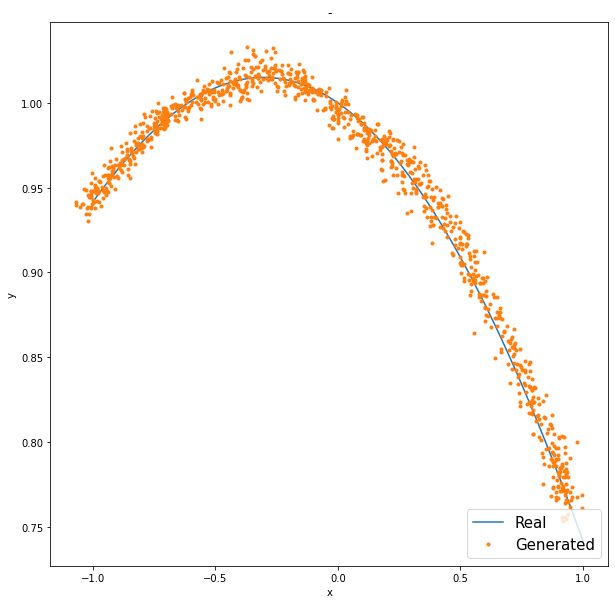

In [10]:
fig = plt.figure(figsize=(10, 10))

plt.plot(train_data[:, 0], train_data[:, 1], label='Real')
plt.plot(generated_data[:, 0], generated_data[:, 1], '.', label='Generated')

plt.xlabel('x')
plt.ylabel('y')
plt.title('-')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()